In [86]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import category_encoders as ce
from sklearn.metrics import f1_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.impute import KNNImputer
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import TimeSeriesSplit
from sktime.forecasting.model_selection import temporal_train_test_split 

## Loading the Data and Exploring

In [2]:
train = pd.read_csv("./train.csv")
store = pd.read_csv("./store.csv")

C:\Users\grott\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3166: DtypeWarning: Columns (7) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [3]:
train.head(10)

,Date,Store,DayOfWeek,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday
0,2013-01-01,1115.0,2.0,0.0,0.0,0.0,0.0,a,1.0
1,2013-01-01,379.0,2.0,0.0,0.0,0.0,0.0,a,1.0
2,2013-01-01,378.0,2.0,0.0,0.0,0.0,0.0,a,1.0
3,2013-01-01,377.0,2.0,0.0,0.0,0.0,0.0,a,1.0
4,2013-01-01,376.0,2.0,0.0,0.0,0.0,0.0,a,1.0
5,2013-01-01,375.0,2.0,0.0,0.0,0.0,0.0,a,1.0
6,2013-01-01,374.0,2.0,0.0,0.0,0.0,0.0,a,1.0
7,2013-01-01,373.0,2.0,0.0,0.0,0.0,0.0,a,1.0
8,2013-01-01,372.0,2.0,0.0,0.0,0.0,NaN,a,1.0
9,2013-01-01,371.0,2.0,0.0,0.0,0.0,0.0,a,1.0


In [4]:
# Check missing values in train
train.isnull().sum() / train.shape[0]

Date             0.000000
Store            0.030263
DayOfWeek        0.029818
Sales            0.029833
Customers        0.029934
Open             0.030083
Promo            0.030095
StateHoliday     0.030189
SchoolHoliday    0.030320
dtype: float64

In [5]:
store.head(10)

,Store,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
0,1,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN
1,2,a,a,570.0,11.0,2007.0,1,13.0,2010.0,"Jan,Apr,Jul,Oct"
2,3,a,a,14130.0,12.0,2006.0,1,14.0,2011.0,"Jan,Apr,Jul,Oct"
3,4,c,c,620.0,9.0,2009.0,0,NaN,NaN,NaN
4,5,a,a,29910.0,4.0,2015.0,0,NaN,NaN,NaN
5,6,a,a,310.0,12.0,2013.0,0,NaN,NaN,NaN
6,7,a,c,24000.0,4.0,2013.0,0,NaN,NaN,NaN
7,8,a,a,7520.0,10.0,2014.0,0,NaN,NaN,NaN
8,9,a,c,2030.0,8.0,2000.0,0,NaN,NaN,NaN
9,10,a,a,3160.0,9.0,2009.0,0,NaN,NaN,NaN


In [6]:
# Remove stores with no IDs since predictions will be based on stores
train.dropna(axis=0, inplace=True, subset=["Store"])

In [7]:
# Check for missing values in stores table
store.isnull().sum() / store.shape[0]

Store                        0.000000
StoreType                    0.000000
Assortment                   0.000000
CompetitionDistance          0.002691
CompetitionOpenSinceMonth    0.317489
CompetitionOpenSinceYear     0.317489
Promo2                       0.000000
Promo2SinceWeek              0.487892
Promo2SinceYear              0.487892
PromoInterval                0.487892
dtype: float64

In [8]:
# Joining datasets together
dataset = train.join(store.set_index("Store"), on="Store")
dataset.head(10)

,Date,Store,DayOfWeek,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
0,2013-01-01,1115.0,2.0,0.0,0.0,0.0,0.0,a,1.0,d,c,5350.0,NaN,NaN,1,22.0,2012.0,"Mar,Jun,Sept,Dec"
1,2013-01-01,379.0,2.0,0.0,0.0,0.0,0.0,a,1.0,d,a,6630.0,NaN,NaN,0,NaN,NaN,NaN
2,2013-01-01,378.0,2.0,0.0,0.0,0.0,0.0,a,1.0,a,c,2140.0,8.0,2012.0,0,NaN,NaN,NaN
3,2013-01-01,377.0,2.0,0.0,0.0,0.0,0.0,a,1.0,a,c,100.0,6.0,2010.0,1,18.0,2010.0,"Feb,May,Aug,Nov"
4,2013-01-01,376.0,2.0,0.0,0.0,0.0,0.0,a,1.0,a,a,160.0,8.0,2012.0,0,NaN,NaN,NaN
5,2013-01-01,375.0,2.0,0.0,0.0,0.0,0.0,a,1.0,a,c,15710.0,2.0,2013.0,1,37.0,2009.0,"Jan,Apr,Jul,Oct"
6,2013-01-01,374.0,2.0,0.0,0.0,0.0,0.0,a,1.0,a,a,1150.0,9.0,2007.0,0,NaN,NaN,NaN
7,2013-01-01,373.0,2.0,0.0,0.0,0.0,0.0,a,1.0,d,c,11120.0,NaN,NaN,1,22.0,2012.0,"Jan,Apr,Jul,Oct"
8,2013-01-01,372.0,2.0,0.0,0.0,0.0,NaN,a,1.0,d,c,4880.0,8.0,2010.0,1,18.0,2014.0,"Jan,Apr,Jul,Oct"
9,2013-01-01,371.0,2.0,0.0,0.0,0.0,0.0,a,1.0,d,c,1970.0,7.0,2009.0,1,45.0,2014.0,"Feb,May,Aug,Nov"


In [9]:
# Checking Data Types
dataset.dtypes

Date                          object
Store                        float64
DayOfWeek                    float64
Sales                        float64
Customers                    float64
Open                         float64
Promo                        float64
StateHoliday                  object
SchoolHoliday                float64
StoreType                     object
Assortment                    object
CompetitionDistance          float64
CompetitionOpenSinceMonth    float64
CompetitionOpenSinceYear     float64
Promo2                         int64
Promo2SinceWeek              float64
Promo2SinceYear              float64
PromoInterval                 object
dtype: object

In [10]:
# Inspecting nulls after joining
dataset.isnull().sum() / dataset.shape[0]

Date                         0.000000
Store                        0.000000
DayOfWeek                    0.029811
Sales                        0.029823
Customers                    0.029938
Open                         0.030140
Promo                        0.030207
StateHoliday                 0.030074
SchoolHoliday                0.030376
StoreType                    0.000000
Assortment                   0.000000
CompetitionDistance          0.002644
CompetitionOpenSinceMonth    0.317605
CompetitionOpenSinceYear     0.317605
Promo2                       0.000000
Promo2SinceWeek              0.490959
Promo2SinceYear              0.490959
PromoInterval                0.490959
dtype: float64

In [11]:
# Removing rows with many nulls
dataset.dropna(axis=0, inplace=True, subset=["CompetitionOpenSinceMonth", "CompetitionOpenSinceYear", "Promo2SinceWeek", "Promo2SinceYear", "PromoInterval"])

In [12]:
# Checking other NAs and what to do
dataset["DayOfWeek"].unique()

# DayofWeek has nans nas could be filled throug date column --> easier could be derived from it and original dropped --> DONE
# Open fill nas through date if ir is not a Sunday
# Sales Impute
# Customers can be imputed (but clarify if we need it)
# Promo replace NAs with "no promotion"
# StateHoliday data has different data types for same values
# SchoolHoliday can be filled based on actual but could be dropped since likely irrelevant


array([ 2., nan,  3.,  4.,  5.,  6.,  7.,  1.])

In [13]:
# Replacing DayOfWeek with the correct number
dataset = dataset.astype({"Date": "datetime64[ns]"})
dataset["DayOfWeek"] = dataset["Date"].dt.weekday

# Checking what weekdays are there when NAs for Open
dataset[dataset["Open"].isnull()]["DayOfWeek"].unique()

# Put correct data types
#dataset = dataset.astype({"Date": "datetime64[ns]", "Store": int, "Customers": int})

array([1, 2, 3, 4, 5, 6, 0], dtype=int64)

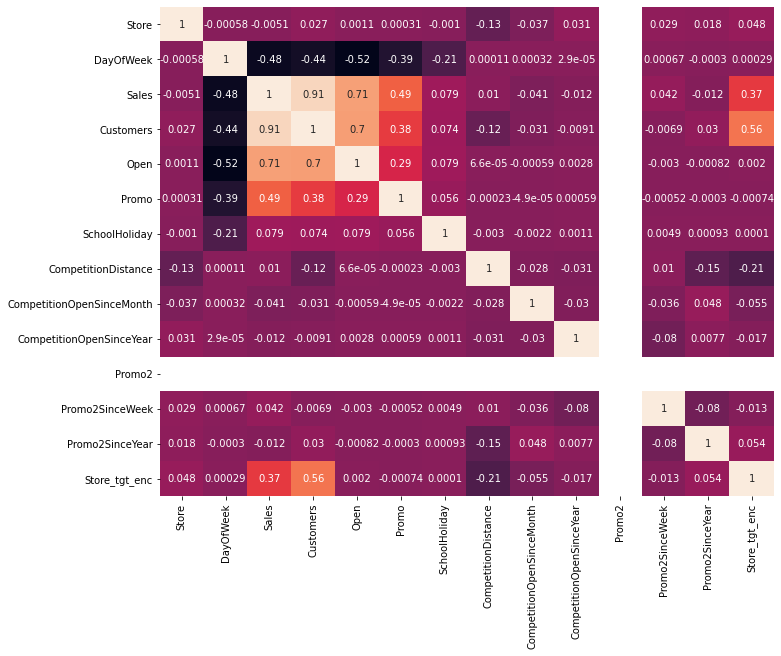

In [100]:
# Check correlations
plt.subplots(figsize=(11,9))
sns.heatmap(dataset.corr(), cbar=False, annot=True)

## Encoding

In [99]:
# Target Encoding for Store
ce_te = ce.TargetEncoder(cols=["Store"])

# Setting on customers first
ce_te.fit(dataset["Store"], dataset["Customers"])
dataset["Store_tgt_enc"] = ce_te.transform(dataset["Store"])

# Below code not applied because FE did not yield high correlation to target after all

# Frequency Encoding
# ce_fe = dataset.groupby("Store").size()
# ce_fe = ce_fe / len(dataset)
# dataset["Store_frq_enc"] = dataset["Store"].map(ce_fe)

# dataset.drop(axis=1, labels=["Store_frq_enc"], inplace=True)



## Test / Train Split

In [90]:
cols_to_exclude = ["Sales"]

x_train, x_test, y_train, y_test = train_test_split(dataset.loc[:, (dataset.columns != "Sales")], dataset["Sales"], 
                                                    test_size=0.2, random_state=None)

In [92]:
x_test["Date"]

632606   2014-07-26
355274   2013-11-15
262022   2013-08-23
561767   2014-05-19
195103   2013-06-24
            ...    
555455   2014-05-14
156467   2013-05-21
452732   2014-02-11
112689   2013-04-12
261038   2013-08-23
Name: Date, Length: 40215, dtype: datetime64[ns]

### Imputing

In [66]:
imputer = KNNImputer(weights="distance")
y_train = imputer.fit_transform(np.array(y_train).reshape(-1,1))
y_train


array([[4170.],
       [3673.],
       [6772.],
       ...,
       [9318.],
       [   0.],
       [   0.]])

#### Adjusting Datatypes

## Fit and Predict

In [62]:
rfr = RandomForestRegressor(max_depth=5, n_estimators=150)
rfr.fit(x_train[["Customers", "Open"]], y_train)
y_pred = rfr.predict(x_test[["Customers", "Open"]])

ValueError: Input contains NaN, infinity or a value too large for dtype('float32').

In [60]:
x_train.dtypes

Date                         datetime64[ns]
Store                               float64
DayOfWeek                             int64
Customers                           float64
Open                                float64
Promo                               float64
StateHoliday                         object
SchoolHoliday                       float64
StoreType                            object
Assortment                           object
CompetitionDistance                 float64
CompetitionOpenSinceMonth           float64
CompetitionOpenSinceYear            float64
Promo2                                int64
Promo2SinceWeek                     float64
Promo2SinceYear                     float64
PromoInterval                        object
Store_tgt_enc                       float64
dtype: object

In [69]:
x_train, x_test, y_train, y_test = temporal_train_test_split(y=dataset["Sales"], X=dataset.loc[:, (dataset.columns != "Sales")], test_size=0.2, train_size=0.8)

In [72]:
y_train

,Date,Store,DayOfWeek,Customers,Open,Promo,StateHoliday,SchoolHoliday,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval,Store_tgt_enc
3,2013-01-01,377.0,1,0.0,0.0,0.0,a,1.0,a,c,100.0,6.0,2010.0,1,18.0,2010.0,"Feb,May,Aug,Nov",775.229630
5,2013-01-01,375.0,1,0.0,0.0,0.0,a,1.0,a,c,15710.0,2.0,2013.0,1,37.0,2009.0,"Jan,Apr,Jul,Oct",622.479853
8,2013-01-01,372.0,1,0.0,0.0,NaN,a,1.0,d,c,4880.0,8.0,2010.0,1,18.0,2014.0,"Jan,Apr,Jul,Oct",623.851376
9,2013-01-01,371.0,1,0.0,0.0,0.0,a,1.0,d,c,1970.0,7.0,2009.0,1,45.0,2014.0,"Feb,May,Aug,Nov",451.744841
10,2013-01-01,370.0,1,0.0,0.0,0.0,a,1.0,d,a,8250.0,10.0,2000.0,1,31.0,2009.0,"Jan,Apr,Jul,Oct",527.011029
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
506599,2014-03-31,61.0,0,758.0,1.0,NaN,0,0.0,a,c,350.0,12.0,2007.0,1,1.0,2012.0,"Jan,Apr,Jul,Oct",455.155678
506601,2014-03-31,59.0,0,1045.0,1.0,1.0,0,0.0,a,c,2840.0,6.0,2007.0,1,14.0,2011.0,"Jan,Apr,Jul,Oct",474.348794
506602,2014-03-31,58.0,0,916.0,1.0,1.0,0,0.0,a,c,7340.0,5.0,2008.0,1,27.0,2012.0,"Jan,Apr,Jul,Oct",411.321012
506604,2014-03-31,56.0,0,576.0,1.0,1.0,0,0.0,d,c,6620.0,3.0,2012.0,1,10.0,2014.0,"Mar,Jun,Sept,Dec",393.036697
